Understanding the Data

In [148]:
import os

base_path = r"C:\Users\abedi\OneDrive\Desktop\TumorDetectionProject\data"

# Updated subfolders
for folder in ["Training1", "Training2", "Testing1", "Testing2"]:
    print(f"\n{folder.upper()}")
    folder_path = os.path.join(base_path, folder)
    if os.path.exists(folder_path):
        for cls in os.listdir(folder_path):
            cls_path = os.path.join(folder_path, cls)
            if os.path.isdir(cls_path):
                count = len(os.listdir(cls_path))
                print(f"{cls}: {count} images")
    else:
        print(f"Folder not found: {folder_path}")


TRAINING1
glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images

TRAINING2
glioma: 826 images
meningioma: 822 images
notumor: 395 images
pituitary: 827 images

TESTING1
glioma: 300 images
meningioma: 306 images
notumor: 405 images
pituitary: 300 images

TESTING2
glioma: 100 images
meningioma: 115 images
notumor: 105 images
pituitary: 74 images


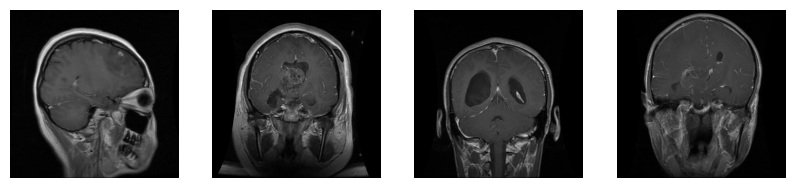

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# Pick one of the training subfolders
folder = os.path.join(base_path, "training1", "glioma")  # or "training2"

# Sample 4 random images
sample_images = random.sample(os.listdir(folder), 4)

plt.figure(figsize=(10, 4))
for i, img_name in enumerate(sample_images):
    img = cv2.imread(os.path.join(folder, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [150]:
import cv2

img = cv2.imread(os.path.join(folder, sample_images[0]))
print("Image shape:", img.shape)

Image shape: (512, 512, 3)


Data Augmentation

In [151]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training folders
train_dir1 = r"C:\Users\abedi\OneDrive\Desktop\TumorDetectionProject\data\Training1"
train_dir2 = r"C:\Users\abedi\OneDrive\Desktop\TumorDetectionProject\data\Training2"

# Test folders (used as validation)
test_dir1 = r"C:\Users\abedi\OneDrive\Desktop\TumorDetectionProject\data\Testing1"
test_dir2 = r"C:\Users\abedi\OneDrive\Desktop\TumorDetectionProject\data\Testing2"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input

def augment_and_preprocess(x):
    x = tf.image.adjust_contrast(x, 1.5)
    return preprocess_input(x)

train_datagen = ImageDataGenerator(
    preprocessing_function=augment_and_preprocess,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    brightness_range=[0.9, 1.1],
    fill_mode='constant',
    cval=0,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Data Generators
train_gen1 = train_datagen.flow_from_directory(
    train_dir1,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True
)

train_gen2 = train_datagen.flow_from_directory(
    train_dir2,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True
)

test_gen1 = test_datagen.flow_from_directory(
    test_dir1,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

test_gen2 = test_datagen.flow_from_directory(
    test_dir2,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [153]:
# Wrap the generator
def generator_to_dataset(gen):
    return tf.data.Dataset.from_generator(
        lambda: gen,
        output_types=(tf.float32, tf.float32),
        output_shapes=((None, 224, 224, 3), (None, 4))  # batch dimension = None
    )

# Create datasets
ds_train1 = generator_to_dataset(train_gen1)
ds_train2 = generator_to_dataset(train_gen2)
ds_test1 = generator_to_dataset(test_gen1)
ds_test2 = generator_to_dataset(test_gen2)

# Combine
train_dataset = ds_train1.concatenate(ds_train2)
test_dataset = ds_test1.concatenate(ds_test2)

# DO NOT call .batch() here — batches are already in the generator

Visualizing Augmented Data

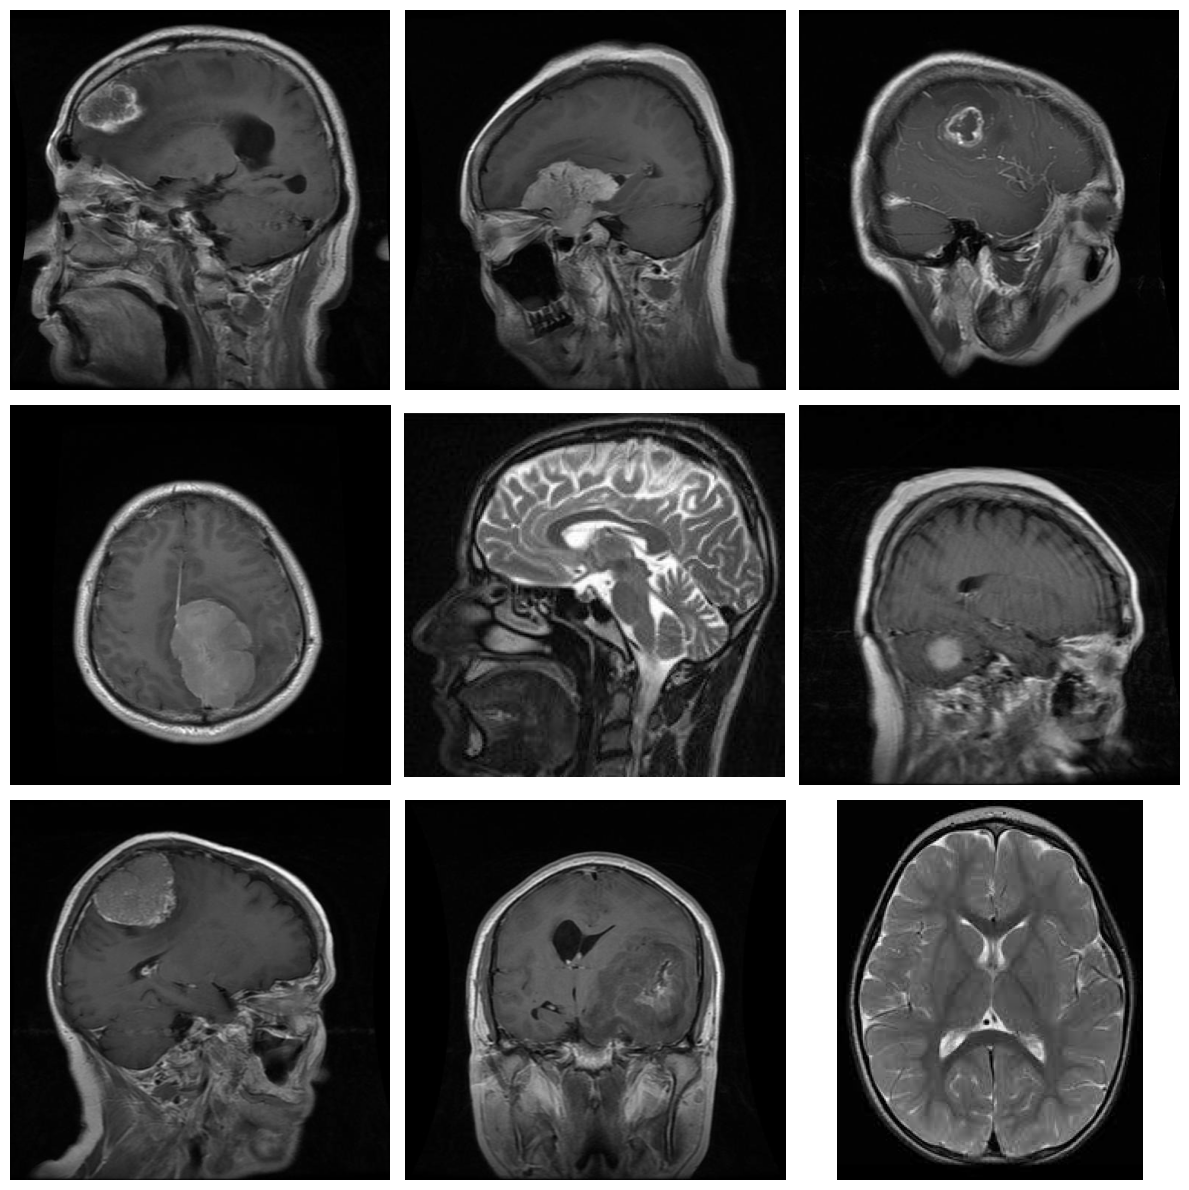

In [154]:
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import random

# Define your training subfolders
training_folders = [train_dir1, train_dir2]

num_images_to_show = 9  # total images to visualize
sample_paths = []

# Collect all class subfolders
all_class_subfolders = []
for folder in training_folders:
    all_class_subfolders += [os.path.join(folder, cls) for cls in os.listdir(folder) if os.path.isdir(os.path.join(folder, cls))]

# Randomly pick 9 images across all classes and folders
while len(sample_paths) < num_images_to_show:
    cls_folder = random.choice(all_class_subfolders)
    img_name = random.choice(os.listdir(cls_folder))
    sample_paths.append(os.path.join(cls_folder, img_name))

# Load images and apply simple augmentations
augmented_images = []
for path in sample_paths:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Simple augmentations
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    img = tf.image.random_flip_left_right(img)
    augmented_images.append(img)

# Deprocess for visualization
def deprocess_mri_image(x):
    x = (x - tf.reduce_min(x)) / (tf.reduce_max(x) - tf.reduce_min(x) + 1e-8)
    return x.numpy()

# Plot augmented images in 3x3 grid
rows = 3
cols = 3
plt.figure(figsize=(12, 12))  # bigger figure for large images
for i, img in enumerate(augmented_images):
    plt.subplot(rows, cols, i+1)
    plt.imshow(deprocess_mri_image(img), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Transfer Learning

Pre-trained CNN (EfficientNetV2-S)

In [155]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
import numpy as np

Load Pretrained EfficientNetV2-S Model (No Top)

In [156]:
base_model = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

Freeze all layers (feature extraction phase)

In [157]:
for layer in base_model.layers:
    layer.trainable = False

Add Classification Head

In [158]:
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)

x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.4)(x)

output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

Compilation and Callbacks

In [159]:
early_stop1 = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
checkpoint = ModelCheckpoint('best_efficientnetv2s_model.h5', monitor='val_accuracy', save_best_only=True)

loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=loss_fn,
    metrics=['accuracy']
)

Compute Class Weights

In [160]:
from sklearn.utils import class_weight

all_classes = np.concatenate([train_gen1.classes, train_gen2.classes])
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_classes),
    y=all_classes
)
class_weights = dict(enumerate(class_weights))

Training Phase 1: Train Head

In [161]:
callbacks_phase1 = [early_stop1, reduce_lr, checkpoint]
steps_per_epoch = len(train_gen1) + len(train_gen2)  # sum of batches from both generators
validation_steps = len(test_gen1) + len(test_gen2)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks_phase1,
    class_weight=class_weights
)

Epoch 1/50


269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4878 - loss: 1.5379

269/269 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - accuracy: 0.5758 - loss: 1.3179 - val_accuracy: 0.6821 - val_loss: 1.0959 - learning_rate: 1.0000e-04
Epoch 2/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6851 - loss: 1.0714

269/269 ━━━━━━━━━━━━━━━━━━━━ 364s 1s/step - accuracy: 0.6965 - loss: 1.0462 - val_accuracy: 0.7528 - val_loss: 0.9285 - learning_rate: 1.0000e-04
Epoch 3/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7332 - loss: 0.9738

269/269 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.7379 - loss: 0.9696 - val_accuracy: 0.8187 - val_loss: 0.8213 - learning_rate: 1.0000e-04
Epoch 4/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.7619 - loss: 0.9264 - val_accuracy: 0.7493 - val_loss: 0.8985 - learning_rate: 1.0000e-04
Epoch 5/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.7707 - loss: 0.8979 - val_accuracy: 0.7759 - val_loss: 0.8528 - learning_rate: 1.0000e-04
Epoch 6/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7825 - loss: 0.8835

269/269 ━━━━━━━━━━━━━━━━━━━━ 356s 1s/step - accuracy: 0.7861 - loss: 0.8792 - val_accuracy: 0.8302 - val_loss: 0.7791 - learning_rate: 1.0000e-04
Epoch 7/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 356s 1s/step - accuracy: 0.8033 - loss: 0.8534 - val_accuracy: 0.7968 - val_loss: 0.8386 - learning_rate: 1.0000e-04
Epoch 8/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.7994 - loss: 0.8531 - val_accuracy: 0.8159 - val_loss: 0.7972 - learning_rate: 1.0000e-04
Epoch 9/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8126 - loss: 0.8251

269/269 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.8110 - loss: 0.8278 - val_accuracy: 0.8488 - val_loss: 0.7539 - learning_rate: 1.0000e-04
Epoch 10/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.8225 - loss: 0.8164 - val_accuracy: 0.7794 - val_loss: 0.8404 - learning_rate: 1.0000e-04
Epoch 11/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.8262 - loss: 0.8050 - val_accuracy: 0.8431 - val_loss: 0.7679 - learning_rate: 1.0000e-04
Epoch 12/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8252 - loss: 0.8024

269/269 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - accuracy: 0.8280 - loss: 0.8027 - val_accuracy: 0.8581 - val_loss: 0.7241 - learning_rate: 1.0000e-04
Epoch 13/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - accuracy: 0.8350 - loss: 0.7920 - val_accuracy: 0.7968 - val_loss: 0.8087 - learning_rate: 1.0000e-04
Epoch 14/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - accuracy: 0.8440 - loss: 0.7770 - val_accuracy: 0.8466 - val_loss: 0.7473 - learning_rate: 1.0000e-04
Epoch 15/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8418 - loss: 0.7718

269/269 ━━━━━━━━━━━━━━━━━━━━ 356s 1s/step - accuracy: 0.8461 - loss: 0.7700 - val_accuracy: 0.8673 - val_loss: 0.7236 - learning_rate: 1.0000e-04
Epoch 16/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.8511 - loss: 0.7679 - val_accuracy: 0.8025 - val_loss: 0.8135 - learning_rate: 1.0000e-04
Epoch 17/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.8524 - loss: 0.7586 - val_accuracy: 0.8651 - val_loss: 0.7141 - learning_rate: 1.0000e-04
Epoch 18/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8582 - loss: 0.7493

269/269 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.8568 - loss: 0.7518 - val_accuracy: 0.8749 - val_loss: 0.7016 - learning_rate: 1.0000e-04
Epoch 19/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 356s 1s/step - accuracy: 0.8637 - loss: 0.7416 - val_accuracy: 0.8153 - val_loss: 0.7896 - learning_rate: 1.0000e-04
Epoch 20/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8526 - loss: 0.7508

269/269 ━━━━━━━━━━━━━━━━━━━━ 356s 1s/step - accuracy: 0.8572 - loss: 0.7471 - val_accuracy: 0.8772 - val_loss: 0.6899 - learning_rate: 1.0000e-04
Epoch 21/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8597 - loss: 0.7447

269/269 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.8652 - loss: 0.7384 - val_accuracy: 0.8812 - val_loss: 0.6927 - learning_rate: 1.0000e-04
Epoch 22/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.8731 - loss: 0.7277 - val_accuracy: 0.8031 - val_loss: 0.7992 - learning_rate: 1.0000e-04
Epoch 23/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.8801 - loss: 0.7195 - val_accuracy: 0.8801 - val_loss: 0.6804 - learning_rate: 1.0000e-04
Epoch 24/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8814 - loss: 0.7147

269/269 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.8799 - loss: 0.7153 - val_accuracy: 0.8917 - val_loss: 0.6732 - learning_rate: 1.0000e-04
Epoch 25/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.8703 - loss: 0.7245 - val_accuracy: 0.8263 - val_loss: 0.7673 - learning_rate: 1.0000e-04
Epoch 26/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8766 - loss: 0.7130

269/269 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.8805 - loss: 0.7089 - val_accuracy: 0.8981 - val_loss: 0.6603 - learning_rate: 1.0000e-04
Epoch 27/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.8837 - loss: 0.7088 - val_accuracy: 0.8841 - val_loss: 0.6796 - learning_rate: 1.0000e-04
Epoch 28/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.8818 - loss: 0.7033 - val_accuracy: 0.8361 - val_loss: 0.7605 - learning_rate: 1.0000e-04
Epoch 29/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.8855 - loss: 0.6979 - val_accuracy: 0.8854 - val_loss: 0.6612 - learning_rate: 1.0000e-04
Epoch 30/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.8869 - loss: 0.6937 - val_accuracy: 0.8806 - val_loss: 0.6758 - learning_rate: 2.0000e-05
Epoch 31/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - accuracy: 0.8918 - loss: 0.6887 - val_accuracy: 0.8309 - val_loss: 0.7437 - learning_rate: 2.0000e-05
Epoch 32/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 

269/269 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.8904 - loss: 0.6921 - val_accuracy: 0.8998 - val_loss: 0.6467 - learning_rate: 2.0000e-05
Epoch 33/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.8907 - loss: 0.6845 - val_accuracy: 0.8795 - val_loss: 0.6760 - learning_rate: 2.0000e-05
Epoch 34/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.8951 - loss: 0.6819 - val_accuracy: 0.8518 - val_loss: 0.7175 - learning_rate: 2.0000e-05
Epoch 35/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.8934 - loss: 0.6821 - val_accuracy: 0.8981 - val_loss: 0.6425 - learning_rate: 2.0000e-05
Epoch 36/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.9000 - loss: 0.6766 - val_accuracy: 0.8772 - val_loss: 0.6776 - learning_rate: 2.0000e-05
Epoch 37/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.8932 - loss: 0.6798 - val_accuracy: 0.8512 - val_loss: 0.7167 - learning_rate: 2.0000e-05
Epoch 38/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 

269/269 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - accuracy: 0.8981 - loss: 0.6729 - val_accuracy: 0.9045 - val_loss: 0.6385 - learning_rate: 2.0000e-05
Epoch 39/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.8976 - loss: 0.6725 - val_accuracy: 0.8749 - val_loss: 0.6796 - learning_rate: 2.0000e-05
Epoch 40/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.8962 - loss: 0.6772 - val_accuracy: 0.8477 - val_loss: 0.7149 - learning_rate: 2.0000e-05
Epoch 41/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9000 - loss: 0.6729

269/269 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.9028 - loss: 0.6709 - val_accuracy: 0.9056 - val_loss: 0.6377 - learning_rate: 2.0000e-05
Epoch 42/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.8990 - loss: 0.6723 - val_accuracy: 0.8662 - val_loss: 0.6875 - learning_rate: 2.0000e-05
Epoch 43/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.8976 - loss: 0.6761 - val_accuracy: 0.8709 - val_loss: 0.6908 - learning_rate: 2.0000e-05
Epoch 44/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - accuracy: 0.9002 - loss: 0.6691 - val_accuracy: 0.9027 - val_loss: 0.6424 - learning_rate: 2.0000e-05
Epoch 45/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.9029 - loss: 0.6682 - val_accuracy: 0.8726 - val_loss: 0.6945 - learning_rate: 4.0000e-06
Epoch 46/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.9005 - loss: 0.6668 - val_accuracy: 0.8772 - val_loss: 0.6823 - learning_rate: 4.0000e-06
Epoch 47/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 

269/269 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.9035 - loss: 0.6626 - val_accuracy: 0.9073 - val_loss: 0.6394 - learning_rate: 4.0000e-06
Epoch 48/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.9036 - loss: 0.6672 - val_accuracy: 0.8691 - val_loss: 0.6972 - learning_rate: 8.0000e-07
Epoch 49/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - accuracy: 0.9018 - loss: 0.6635 - val_accuracy: 0.8807 - val_loss: 0.6734 - learning_rate: 8.0000e-07
Epoch 50/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - accuracy: 0.9040 - loss: 0.6648 - val_accuracy: 0.9021 - val_loss: 0.6434 - learning_rate: 8.0000e-07


Fine-Tuning Phase

In [162]:
fine_tune_fraction = 0.2
n_layers = len(base_model.layers)
n_unfreeze = int(n_layers * fine_tune_fraction)

for layer in base_model.layers[-n_unfreeze:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

print(f"Unfreezing the last {n_unfreeze} layers out of {n_layers}")

Unfreezing the last 102 layers out of 513


Recompile with lower LR

In [163]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=loss_fn,
    metrics=['accuracy']
)

Fine-tune Callbacks

In [164]:
early_stop_finetune = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr_finetune = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
checkpoint_finetune = ModelCheckpoint('fine_tuned_efficientnetv2s_model.h5', monitor='val_accuracy', save_best_only=True)
callbacks_finetune = [early_stop_finetune, reduce_lr_finetune, checkpoint_finetune]

Training Phase 2: Fine-Tune

In [166]:
steps_per_epoch = len(train_gen1) + len(train_gen2)
validation_steps = len(test_gen1) + len(test_gen2)

history_finetune = model.fit(
    train_dataset,
    validation_data=test_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=callbacks_finetune,
    class_weight=class_weights
)

Epoch 1/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9074 - loss: 0.6551

269/269 ━━━━━━━━━━━━━━━━━━━━ 451s 2s/step - accuracy: 0.9057 - loss: 0.6566 - val_accuracy: 0.8599 - val_loss: 0.7053 - learning_rate: 1.0000e-05
Epoch 2/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9127 - loss: 0.6507

269/269 ━━━━━━━━━━━━━━━━━━━━ 468s 2s/step - accuracy: 0.9139 - loss: 0.6510 - val_accuracy: 0.8877 - val_loss: 0.6658 - learning_rate: 1.0000e-05
Epoch 3/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9153 - loss: 0.6472

269/269 ━━━━━━━━━━━━━━━━━━━━ 471s 2s/step - accuracy: 0.9188 - loss: 0.6423 - val_accuracy: 0.9137 - val_loss: 0.6215 - learning_rate: 1.0000e-05
Epoch 4/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 469s 2s/step - accuracy: 0.9234 - loss: 0.6362 - val_accuracy: 0.8645 - val_loss: 0.6987 - learning_rate: 1.0000e-05
Epoch 5/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - accuracy: 0.9251 - loss: 0.6289 - val_accuracy: 0.8992 - val_loss: 0.6355 - learning_rate: 1.0000e-05
Epoch 6/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9232 - loss: 0.6339

269/269 ━━━━━━━━━━━━━━━━━━━━ 463s 2s/step - accuracy: 0.9232 - loss: 0.6308 - val_accuracy: 0.9154 - val_loss: 0.6167 - learning_rate: 2.0000e-06
Epoch 7/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 469s 2s/step - accuracy: 0.9227 - loss: 0.6310 - val_accuracy: 0.8749 - val_loss: 0.6853 - learning_rate: 2.0000e-06
Epoch 8/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 473s 2s/step - accuracy: 0.9228 - loss: 0.6277 - val_accuracy: 0.9091 - val_loss: 0.6233 - learning_rate: 2.0000e-06
Epoch 9/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9248 - loss: 0.6284

269/269 ━━━━━━━━━━━━━━━━━━━━ 466s 2s/step - accuracy: 0.9243 - loss: 0.6274 - val_accuracy: 0.9189 - val_loss: 0.6155 - learning_rate: 4.0000e-07
Epoch 10/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - accuracy: 0.9232 - loss: 0.6284 - val_accuracy: 0.8639 - val_loss: 0.6969 - learning_rate: 4.0000e-07


Load Best Model for Evaluation

In [204]:
from tensorflow.keras.models import load_model
model = load_model('fine_tuned_efficientnetv2s_model.h5')

## Evaluation

41/41 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 918ms/step
Overall Accuracy: 0.8504

Classification Report:

              precision    recall  f1-score   support

      glioma       0.79      0.76      0.77       400
  meningioma       0.82      0.75      0.78       421
     notumor       0.92      0.93      0.93       510
   pituitary       0.86      0.94      0.90       374

    accuracy                           0.85      1705
   macro avg       0.84      0.85      0.85      1705
weighted avg       0.85      0.85      0.85      1705



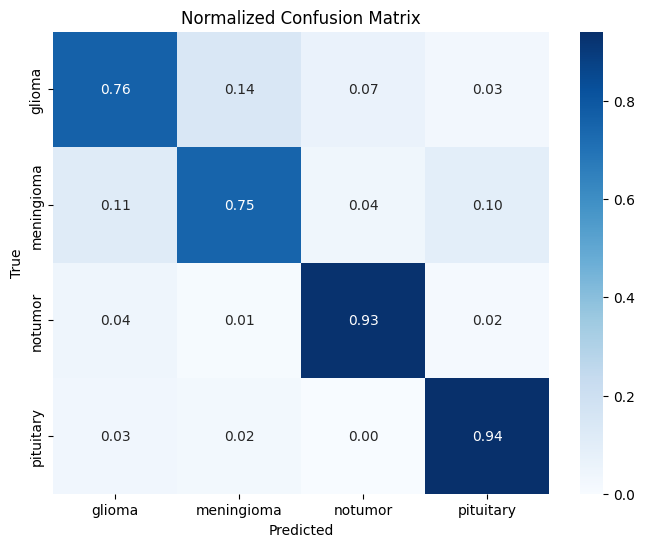

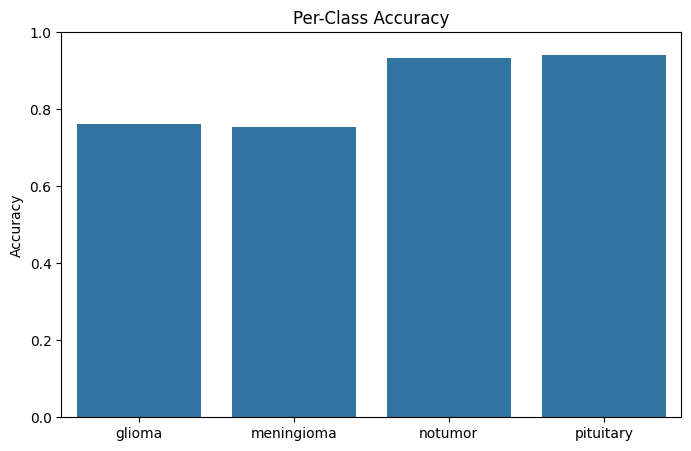

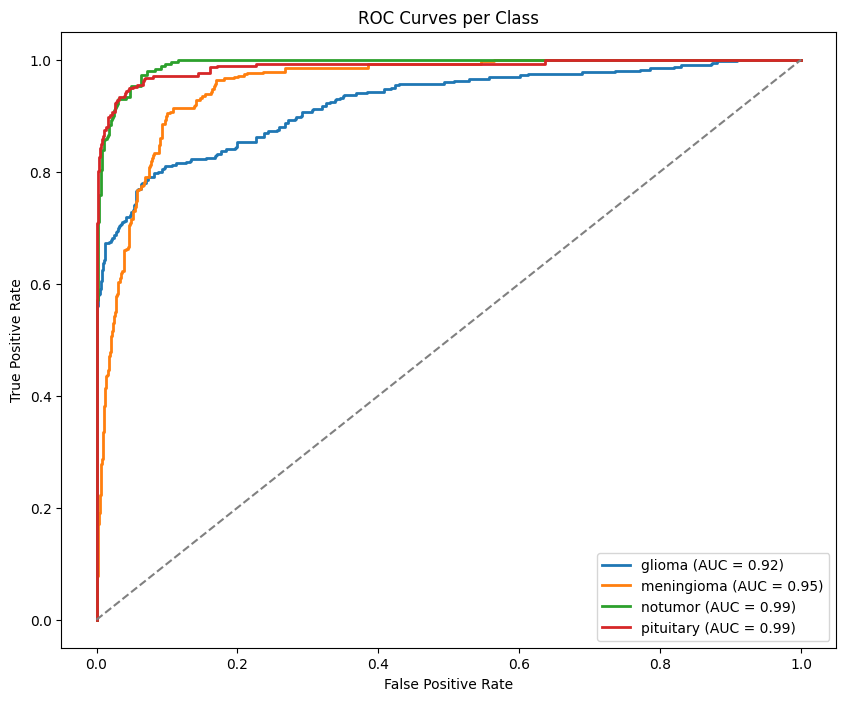

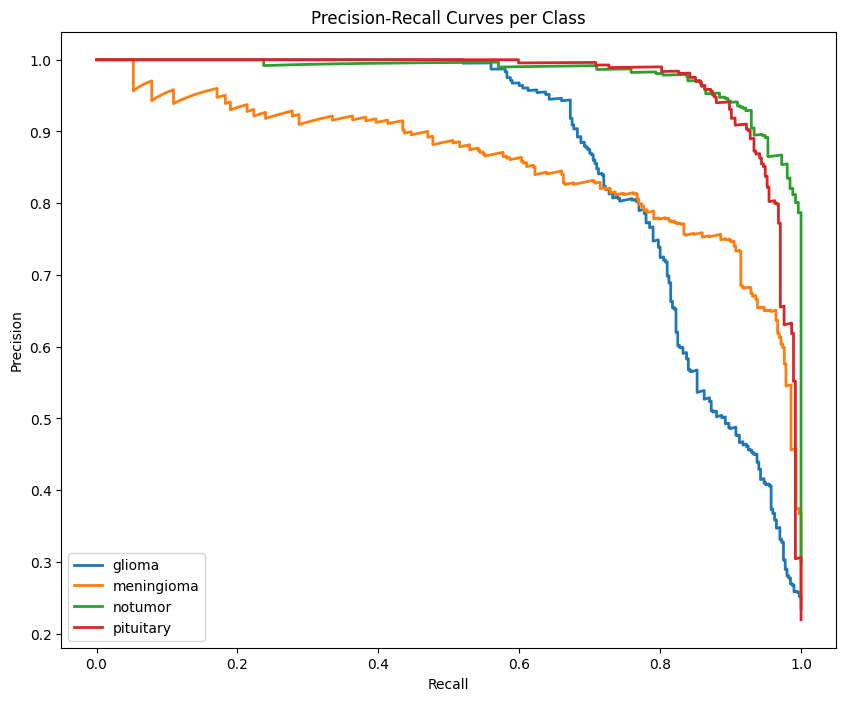

In [205]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    roc_curve, auc, precision_recall_curve
)
import tensorflow as tf

# -----------------------------
# 1. Load model
# -----------------------------
model = load_model("fine_tuned_efficientnetv2s_model.h5")

# -----------------------------
# 2. Predictions on combined test set
# -----------------------------
test_generators = [test_gen1, test_gen2]
y_preds_prob = []
y_trues = []

for gen in test_generators:
    y_prob = model.predict(gen)
    y_true = gen.classes
    y_preds_prob.append(y_prob)
    y_trues.append(y_true)

y_true = np.concatenate(y_trues)
y_preds_prob = np.concatenate(y_preds_prob)
y_pred = np.argmax(y_preds_prob, axis=1)

class_labels = list(test_gen1.class_indices.keys())
n_classes = len(class_labels)

# -----------------------------
# 3. Basic Metrics
# -----------------------------
acc = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {acc:.4f}\n")
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# Per-class Accuracy Bar Plot
per_class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(8, 5))
sns.barplot(x=class_labels, y=per_class_acc)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.show()

# -----------------------------
# 4. ROC & AUC (One-vs-Rest)
# -----------------------------
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_preds_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Class")
plt.legend(loc="lower right")
plt.show()

# -----------------------------
# 5. Precision-Recall Curves
# -----------------------------
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve((y_true == i).astype(int), y_preds_prob[:, i])
    plt.plot(recall, precision, lw=2, label=f"{class_labels[i]}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves per Class")
plt.legend(loc="lower left")
plt.show()